# Optimización de un axicon 3D

**Autor**: Luis Miguel Sánchez Brea

**Fecha**: 31/10/2021

**Objetivo**: Utilizar pyswarm con algún procedimiento de diffractio para la optimización 3D. 
En este caso usamos un sistema de anillos.

**Descripción**: 

- Como función objetivo ponemos un axicon y queremos medir la intensidad central en varias posiciones z.
- Ponemos los anillos iniciales.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffractio import np, sp, plt
from diffractio import mm, um, nm, degrees

from diffractio.scalar_masks_XY import Scalar_mask_XY
from diffractio.utils_math import nearest


number of processors: 8
total memory        : 7.5 Gb
available memory    : 49 %
max frequency       : 4000 GHz


In [3]:

import pyswarms as ps
from pyswarms.utils.functions import single_obj as fx
from pyswarms.single.global_best import GlobalBestPSO
from pyswarms.single.local_best import LocalBestPSO
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
from pyswarms.utils.plotters.formatters import Mesher

## Descripción de la intensidad

In [4]:
def generate_rings_mask(transitions, t_mask, has_draw=False):
    num_rings=len(transitions)
    
    inner_radii = np.zeros(int(num_rings/2))
    outer_radii = np.zeros(int(num_rings/2))

    inner_radii[:]=transitions[0::2]  #Primer argumento: Todas las partículas
    outer_radii[:]=transitions[1::2]
    
    t_mask.rings(r0=(0,0), inner_radius=inner_radii, outer_radius=outer_radii, mask=True)
    t_mask.pupil()
    
    if has_draw:
        t_mask.draw()
    
    return t_mask

In [5]:
def focus_intensity_rings(transitions, t_mask, zs, has_draw=False):
    
    intensities=np.zeros_like(zs)
    transitions.sort()
    
    t_mask=generate_rings_mask(transitions, t_mask, has_draw=False)
    
    i_0,_,_=nearest(t_mask.x,0)
    j_0,_,_=nearest(t_mask.y,0)
    
    for i, z in enumerate(zs):
        u2=t_mask.RS(z=z, verbose=False)
        intensity = u2.intensity()
        intensities[i] = intensity[i_0,j_0]
        
    
        if has_draw:
            u2.draw(has_colorbar='vertical', logarithm=False)
    
    
    return intensities

## Funciones de coste

El número de dimensiones del problema corresponde con el número de transiciones de la red de Damman. El número de órdenes corresponde con los órdenes de difracción de la red.

## Optimization

In [6]:
def cost_function_1(intensities):
    
    return -np.prod(intensities)**(1/len(intensities))

In [7]:
def opt_func_1(Transitions, t_mask, zs):
    num_particles = Transitions.shape[0]  # number of particles
    intensidad = [optimization_loop_1(Transitions[i,:],t_mask, zs) for i in range(num_particles)]
    return intensidad


In [8]:
def optimization_loop_1(transitions, t_mask, zs, has_draw=False):

    intensity = focus_intensity_rings(transitions, t_mask, zs, has_draw=False)
    cost1 = cost_function_1(intensity)
    return cost1

### Otros parámetros a explorar:

In [9]:
def strehl_ratio(I_sample, I_ideal):
    return I_ideal/I_sample

In [10]:
def intensity_max(u, verbose=False):
    intensity_focus=u.intensity()
    intensity_max=intensity_focus.max()
    if verbose:
        print("I_max = {2.2f}".format(intensity_max))
    return intensity_max


In [11]:
def intensity_out(u, radius_out, size=0, mask=None, has_draw=False, verbose=False):
    if size>0:
        u3=u.cut_resample(x_limits=(-size/2,size/2),y_limits=(-size/2,size/2), new_field=True)
    else: 
        u3=u
        size=u.x[-1]
    
    if has_draw:
        u3.draw(logarithm=True)        
        u3.draw_profile([-size,0], [size,0]);

    intensity_focus=u3.intensity()
    intensity_max=intensity_focus.max()        
        
    i_x_max,_,_=nearest(u3.x,0)
    i_y_max,_,_=nearest(u3.y,0)        

    #forma sencilla
    I_optimal=np.zeros_like(u3.u, dtype=float)
    I_optimal[i_y_max,i_x_max]=intensity_max
    mask_size = intensity_focus.size
    
    if mask is None:
        #forma más elaborada
        mask=Scalar_mask_XY(u3.x,u3.y,u3.wavelength)
        mask.circle(r0=(0,0), radius=radius_out)
        mask.inverse_amplitude()
        
    if has_draw:
        mask.draw()
        plt.title('mask')

    mask_size=mask.u.sum()
    error=np.real((mask.u*(intensity_focus-I_optimal)).sum()/mask_size)
    
    if verbose:
        print("error = {:2.2f}".format(error))
    
    return error, mask



## Create example

In [12]:
num_pixels=128
wavelength=0.6328
diameter=1000*um
period = 40*um
x0=np.linspace(-diameter/2,diameter/2,num_pixels)
y0=np.linspace(-diameter/2,diameter/2,num_pixels)

radius_max=x0[-1]

num_transitions_optimal=int(radius_max/period)
print("num rings = {}".format(num_transitions_optimal))

t_rings=Scalar_mask_XY(x0,y0,wavelength)

num rings = 12


### Axicon

In [13]:
def axicon_binary(self, r0, radius, period):
    """axicon_binary. Rings with equal period

    Parameters:
        r0 (float, float): (x0,y0) - center of lens
        radius (float): radius of lens mask
        period (float): distance of rings

    Example:
        axicon_binary(r0=(0 * um, 0 * um), radius=200 * um, period=20 * um)
    """
    
    k = 2 * np.pi / self.wavelength
    x0, y0 = r0

    r = np.sqrt((self.X - x0)**2 + (self.Y - y0)**2)

    if radius>0:
        u_mask = np.zeros_like(self.X)
        ipasa = r < radius
        u_mask[ipasa] = 1

 
    t =  np.cos(2*np.pi* r / period) * u_mask
    
    t[t<=0]=0
    t[t>0]=1

    self.u = t
    return self
    

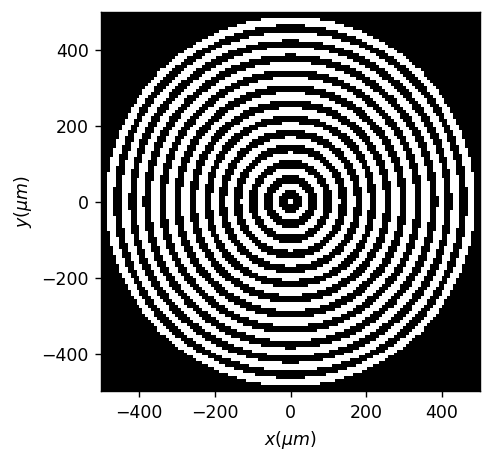

In [14]:
t_axicon=Scalar_mask_XY(x0,y0,wavelength)
t_axicon.axicon_binary(r0=(0,0), radius=radius_max, period=40*um)
t_axicon.draw();

Good result: factor 1.20


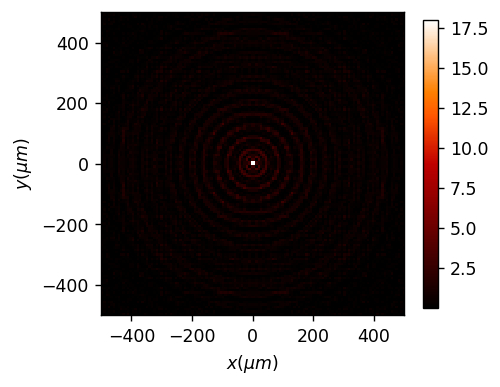

In [15]:
u_axicon=t_axicon.RS(z=15*mm, verbose=True)
u_axicon.draw(logarithm=False, has_colorbar='vertical');


### Ejecución de anilos

In [16]:
radius_max = x0[-1]

transitions=np.linspace(1,radius_max,4*num_transitions_optimal)

print(transitions)

[  1.          11.61702128  22.23404255  32.85106383  43.46808511
  54.08510638  64.70212766  75.31914894  85.93617021  96.55319149
 107.17021277 117.78723404 128.40425532 139.0212766  149.63829787
 160.25531915 170.87234043 181.4893617  192.10638298 202.72340426
 213.34042553 223.95744681 234.57446809 245.19148936 255.80851064
 266.42553191 277.04255319 287.65957447 298.27659574 308.89361702
 319.5106383  330.12765957 340.74468085 351.36170213 361.9787234
 372.59574468 383.21276596 393.82978723 404.44680851 415.06382979
 425.68085106 436.29787234 446.91489362 457.53191489 468.14893617
 478.76595745 489.38297872 500.        ]


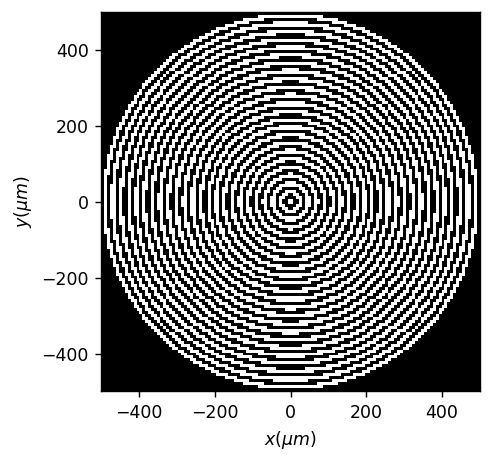

In [17]:
 generate_rings_mask(transitions, t_rings, has_draw=True)

In [52]:
%%time
zs = np.linspace(8*mm, 16*mm, 50)
intensity_rings=focus_intensity_rings(transitions, t_rings, zs, has_draw=False);
print(intensity_rings)

[ 6.86489472  4.7311856   3.83326576  6.72843751 12.70187576 15.1546709
 10.88699903  7.67659009  8.53595504  9.07405614  8.50843489  8.26685924
 10.23582452 14.63366673 17.59490285 16.35696334 12.83009626  9.90688391
  8.65790879  9.09255061 10.73956076 12.61192322 13.73485984 13.66473826
 12.51490443 10.88146352  9.68065188  9.65084525 10.852843   12.67504215
 14.25586172 14.88727326 14.26104211 12.67969488 11.14731864 11.03004887
 13.24200471 17.45591196 22.01447559 24.75750493 24.27222173 20.73652246
 15.81376004 11.70521459  9.97830715 10.84825367 13.23917754 15.47607953
 16.15705206 14.75162337]
CPU times: user 865 ms, sys: 7.74 ms, total: 873 ms
Wall time: 873 ms


(0.0, 25.803716884033086)

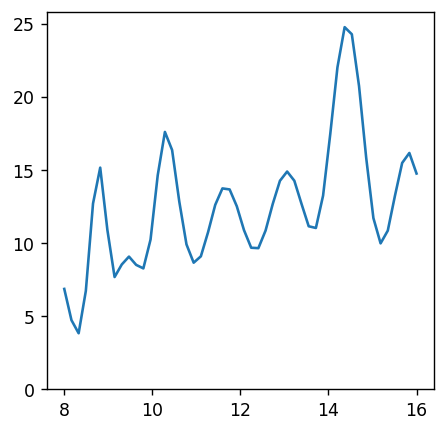

In [53]:
plt.plot(zs/mm,intensity_rings)
plt.ylim(ymin=0)

### Ejecuciones de costes

In [20]:
intensity_rings

array([ 6.86489472,  4.7311856 ,  3.83326576,  6.72843751, 12.70187576,
       15.1546709 , 10.88699903,  7.67659009,  8.53595504,  9.07405614,
        8.50843489,  8.26685924, 10.23582452, 14.63366673, 17.59490285,
       16.35696334, 12.83009626,  9.90688391,  8.65790879,  9.09255061,
       10.73956076, 12.61192322, 13.73485984, 13.66473826, 12.51490443,
       10.88146352,  9.68065188,  9.65084525, 10.852843  , 12.67504215,
       14.25586172, 14.88727326, 14.26104211, 12.67969488, 11.14731864,
       11.03004887, 13.24200471, 17.45591196, 22.01447559, 24.75750493,
       24.27222173, 20.73652246, 15.81376004, 11.70521459,  9.97830715,
       10.84825367, 13.23917754, 15.47607953, 16.15705206, 14.75162337])

In [21]:
cost_value1=cost_function_1(intensity_rings)

print(cost_value1)

-11.811608808595532


# Algorithm

https://pythonhosted.org/pyswarm/

Utilizamos la función GlobalBestPSO de PySwarms para optimizar la función, cuyos argumentos son los siguientes:

- n_particles: # de partículas que el algoritmo utiliza para alcanzar el mínimo.
- dimensions: Las dimensiones corresponde con las trasiciones de nuestra red.
- options: 
   * c1 : float
      cognitive parameter
   * c2 : float
        social parameter
   * w : float
        inertia parameter 
   * 'omega : flaot
       velocity factor
       
- bounds: Restricciones mínima y máxima de las transiciones de la red



In [22]:
zs = np.linspace(8*mm, 16*mm, 12)
num_transitions= num_transitions_optimal #pares
num_iters= 15 # suelen ser más
num_particles = 10 # suelen ser más

In [23]:
min_bound = np.zeros(num_transitions)
max_bound = radius_max*np.ones(num_transitions)
bounds = (min_bound, max_bound)

omega_0 = np.linspace(0.75,0.25,num_transitions)

In [24]:

options = {'c1': 0.5, 'c2': 0.6, 'w': 0.9, 'omega': omega_0}

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=num_transitions, options=options, bounds=bounds)

In [45]:
%%time
zs = np.linspace(8*mm, 16*mm, 12)

cost, transitions_final = optimizer.optimize(opt_func_1, iters=num_iters,  t_mask=t_rings, zs=zs)

2021-11-01 00:55:57,571 - pyswarms.single.global_best - INFO - Optimize for 15 iters with {'c1': 0.5, 'c2': 0.6, 'w': 0.9, 'omega': array([0.75      , 0.70454545, 0.65909091, 0.61363636, 0.56818182,
       0.52272727, 0.47727273, 0.43181818, 0.38636364, 0.34090909,
       0.29545455, 0.25      ])}
pyswarms.single.global_best: 100%|██████████|15/15, best_cost=-14.3
2021-11-01 00:56:26,240 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -14.34533428754811, best pos: [ 24.43838286  68.82224106 105.46686512 131.72700538 161.77144539
 191.14869764 207.64262923 231.82537723 319.06672224 417.18627577
 455.21671489 461.54296737]


CPU times: user 28.7 s, sys: 2.44 ms, total: 28.7 s
Wall time: 28.7 s


In [46]:
transitions_final

array([ 24.43838286,  68.82224106, 105.46686512, 131.72700538,
       161.77144539, 191.14869764, 207.64262923, 231.82537723,
       319.06672224, 417.18627577, 455.21671489, 461.54296737])

<AxesSubplot:title={'center':'Cost History'}, xlabel='Iterations', ylabel='Cost'>

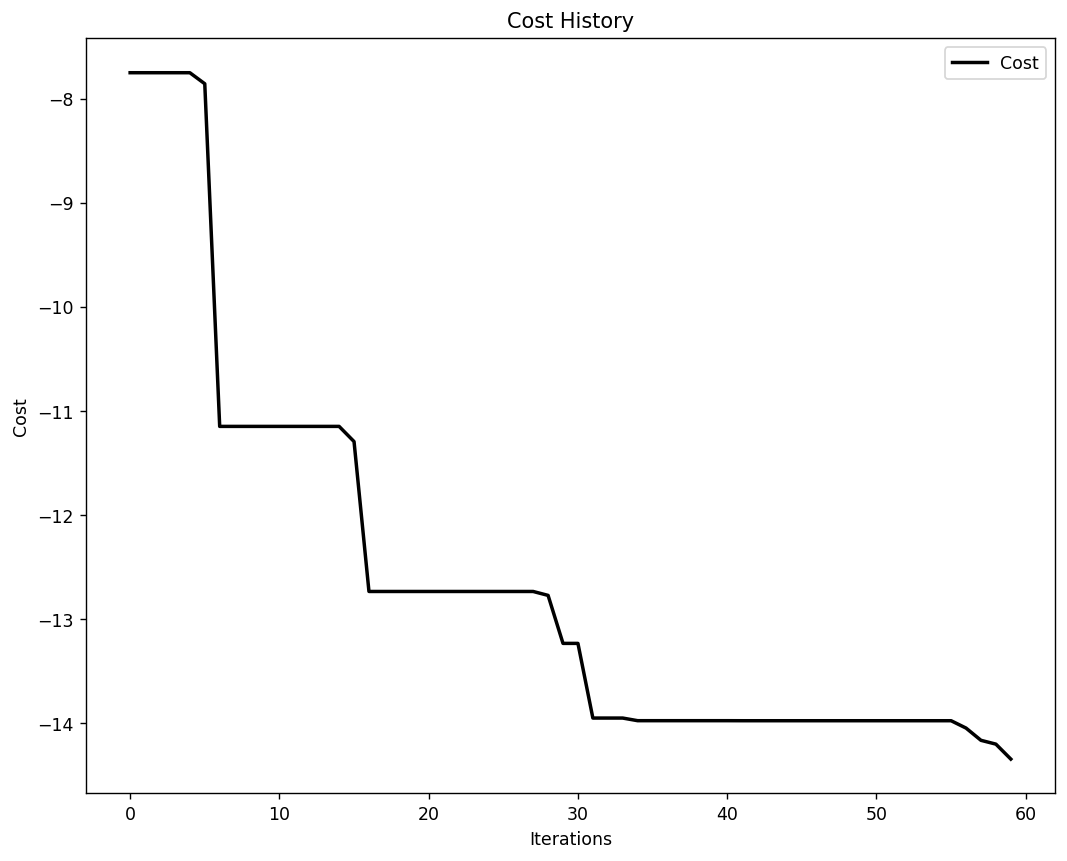

In [47]:
plot_cost_history(cost_history=optimizer.cost_history)

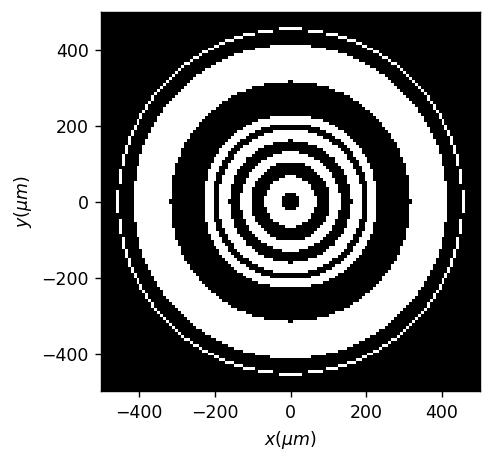

In [48]:
u_final=generate_rings_mask(transitions_final, t_rings, has_draw=True)

In [54]:
%%time
zs = np.linspace(8*mm, 16*mm, 50)
intensity_rings_optimal=focus_intensity_rings(transitions_final, t_rings, zs, has_draw=False)
print(intensity_rings)

[ 6.86489472  4.7311856   3.83326576  6.72843751 12.70187576 15.1546709
 10.88699903  7.67659009  8.53595504  9.07405614  8.50843489  8.26685924
 10.23582452 14.63366673 17.59490285 16.35696334 12.83009626  9.90688391
  8.65790879  9.09255061 10.73956076 12.61192322 13.73485984 13.66473826
 12.51490443 10.88146352  9.68065188  9.65084525 10.852843   12.67504215
 14.25586172 14.88727326 14.26104211 12.67969488 11.14731864 11.03004887
 13.24200471 17.45591196 22.01447559 24.75750493 24.27222173 20.73652246
 15.81376004 11.70521459  9.97830715 10.84825367 13.23917754 15.47607953
 16.15705206 14.75162337]
CPU times: user 819 ms, sys: 83 µs, total: 819 ms
Wall time: 818 ms


(0.0, 29.859821203514095)

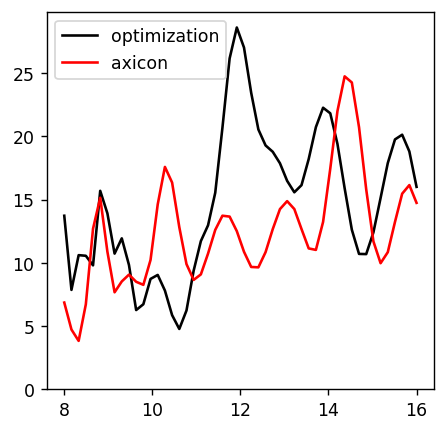

In [55]:
plt.plot(zs/mm,intensity_rings_optimal, 'k', label='optimization')
plt.plot(zs/mm,intensity_rings, 'r', label='axicon')
plt.legend()

plt.ylim(ymin=0)

array([ 6.86489472, 14.72141461,  9.08994677, 16.12178032,  8.75420896,
       13.83846801,  9.52480337, 14.86743723, 12.15674975, 24.06059726,
       10.17569418, 14.75162337])

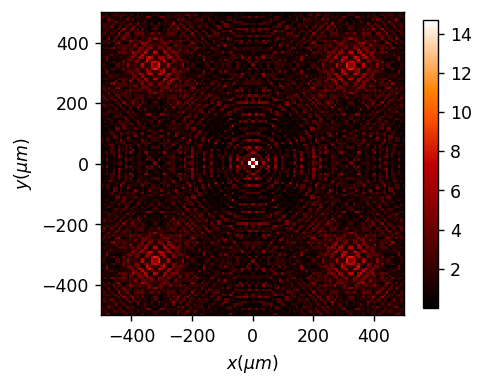

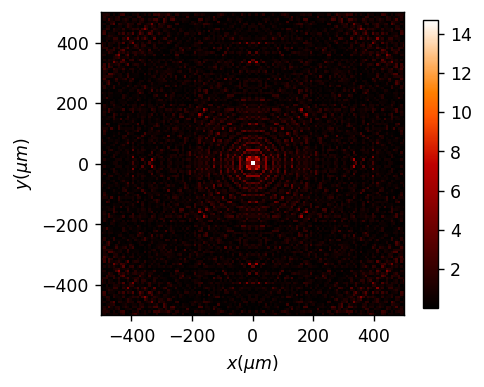

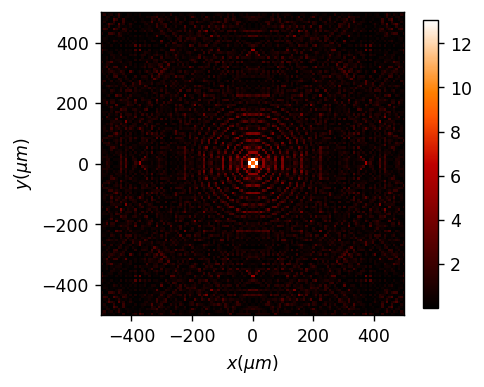

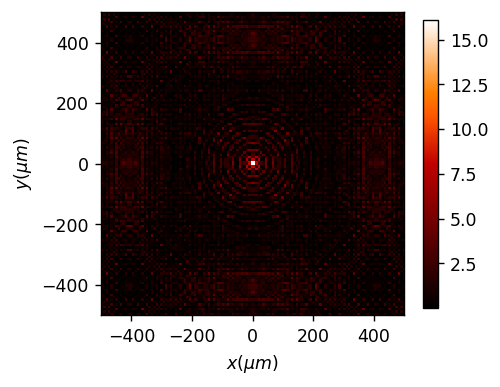

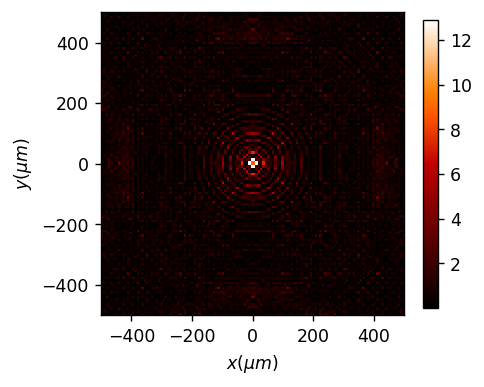

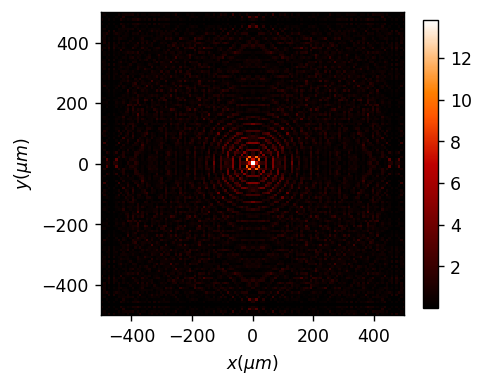

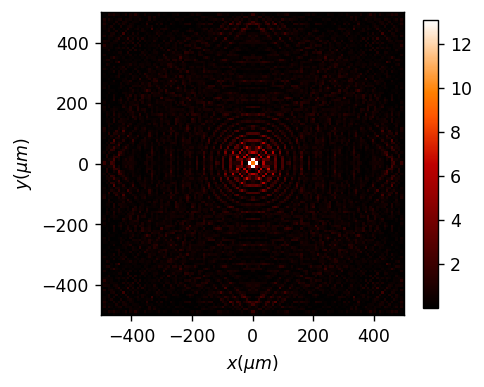

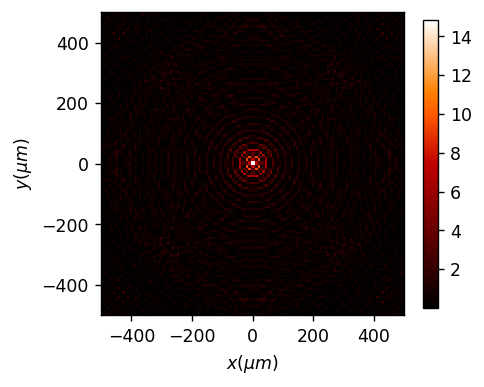

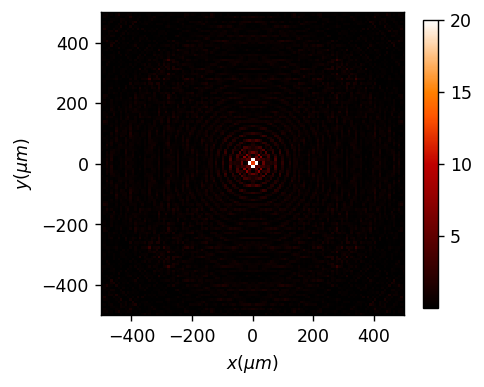

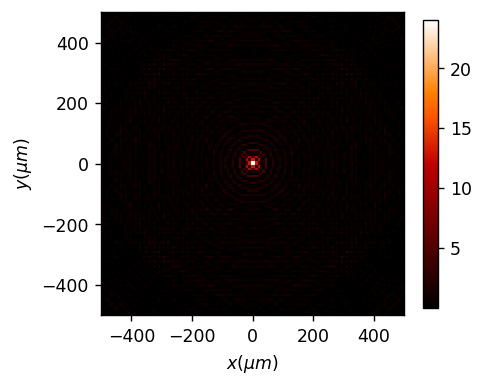

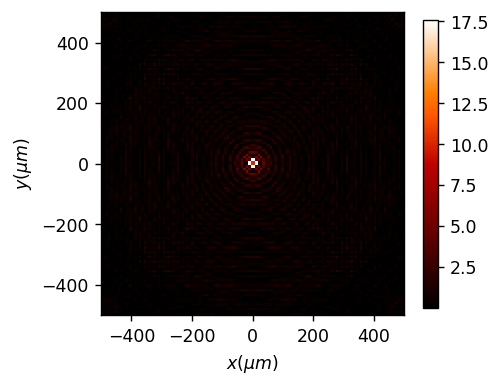

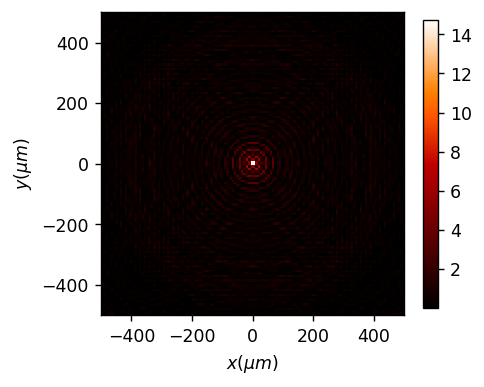

In [51]:
zs = np.linspace(8*mm, 16*mm, 12)
focus_intensity_rings(transitions, t_rings, zs, has_draw=True)

## Conclusiones
- d

## Tareas
- Aprender bien PSO y calcular parámetros. ¿cuál es la velocidad?
- Poner límites y evitar transiciones.
- se podrían poner límites de fabricabilidad, es decir si la distancia entre 2 puntos es pequeña, separarla